# Dataset enrichment

In this notebook we use some tensorflow utilities to enrich our training set. This comes in handy when the dataset available is small, and it is a good way to prevent overfitting. Even variations almost imperceptible to humans, may be huge in terms of pixel values, and may be useful to make the network generalize better.

We use the CIFAR-10 dataset, that contains real world images in 10 classes. Here we only use a smaller number of classes and data, because to see results on the whole dataset requires a lot of training time.


In [1]:
import tensorflow as tf

def conv_weights(filters_size, channels_size, name):
    shape = filters_size + channels_size
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

def conv(x, W, stride, name):
    strides_shape = [1, stride, stride, 1]
    return tf.nn.conv2d(x, W, strides_shape, padding='SAME', name=name)

def pool(x, size, stride, name):
    pool_shape = [1] + size + [1]
    strides_shape = [1, stride, stride, 1]
    return tf.nn.max_pool(x, pool_shape, strides_shape, padding='SAME', name=name)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import cifar10
from cifar10 import  num_channels
num_classes=2
img_size = 32
img_size_cropped = 28

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [6]:
upper_b = (len(class_names)-num_classes)
images_train, cls_train, labels_train = cifar10.load_training_data()
train_size= len(cls_train)
images_train, cls_train, labels_train = images_train[cls_train<num_classes], cls_train[cls_train<num_classes], labels_train[cls_train<num_classes]
images_test, cls_test, labels_test = cifar10.load_test_data()
test_size= len(cls_test)
images_test, cls_test, labels_test = images_test[cls_test<num_classes], cls_test[cls_test<num_classes], labels_test[cls_test<num_classes]
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

train_batch_size= 128
print (images_train.shape)
print (cls_train.shape)
print (labels_train.shape)

labels_train =  labels_train[0:train_size*num_classes/10,0:-upper_b]
labels_test =  labels_test[0:test_size*num_classes/10,0:-upper_b]

print (labels_train.shape)
print (labels_train)

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		10000
- Test-set:		2000
(10000, 32, 32, 3)
(10000,)
(10000, 10)
(10000, 2)
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]


/home/giovanni/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/giovanni/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


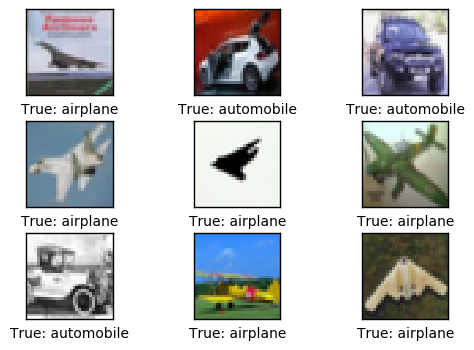

In [7]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)


Here we load the CIFAR-10 and we filter out only the number of classes that we want.


In [8]:
def pre_process_image(image):
    image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.03, upper=10.0)
    image = tf.image.random_brightness(image, max_delta=2)
    image = tf.image.random_saturation(image, lower=0.0, upper=20.0)
    #Some of these functions may produce an output value beyond the [0,1] range of an image
    #To prevent this effect, we limit the range 
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    return image

In [9]:
def resize_util(image):
    image = tf.image.resize_image_with_crop_or_pad(image,
                                                   target_height=img_size_cropped,
                                                   target_width=img_size_cropped)
    image = tf.cast(image, tf.float32)
    return image

In [10]:
def pre_process(images):
    images = tf.map_fn(lambda image: pre_process_image(image), images)
    return images

In [11]:
def resize(images):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: resize_util(image), images)
    return images

Here we define the functions to modify the training images. Notice that all these functions work on tensor, so they are part of the computational graph and will be runned only during the tensorflow session. This may looks a bit counterintuitive, with respect to first preprocess data, and then use them to feed the computational graph.

In [12]:
def random_batch(size, training= True):
    if training == True:
        num_images = len(images_train)
    else:
        num_images = len(images_test)
        
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=size,
                           replace=False)
    # Use the random index to select random images and labels.
    if training == True:
        x_batch = images_train[idx, :, :, :]
        y_batch = labels_train[idx, :]
    else:
        x_batch = images_test[idx, :, :, :]
        y_batch = labels_test[idx, :]
        
    return x_batch.astype(np.float32), y_batch.astype(np.float32)

Here we define a function to feed the computational graph with the unpreprocessed data.

In [13]:
import math
BATCH_SIZE = 100
LEARNING_RATE = 0.0005 
ITERATIONS = 400

input_ =tf.placeholder(tf.float32,[None, 32, 32, 3], name='input_images')
input_images = pre_process(images=input_)
y_ = tf.placeholder(tf.float32, [None, 2], name='labels')
drop_prob = tf.placeholder(tf.float32, name='drop_prob')

W1 = conv_weights([7, 7], [3, 32], 'L1_weights')
b1 = tf.Variable(tf.constant(0.1, shape=[32]), name='L1_biases')
c1 = conv(input_images, W1, stride=1, name='L1_conv')
h1 = tf.nn.relu(tf.nn.bias_add(c1, b1), name='L1_ReLU')
p1 = pool(h1, size=[2, 2], stride=2, name='L1_pool')

tf.summary.image('input', input_images)
tf.summary.histogram('L1_weights', W1)
 
W2 = conv_weights([7,7], [32, 64], 'L2_weights')
b2 = tf.Variable(tf.constant(0.1, shape=[64]), name='L2_biases')
c2 = conv(p1, W2, stride=1, name='L2_conv')
h2 = tf.nn.relu(tf.nn.bias_add(c2, b2), name='L2_ReLU')
p2 = pool(h2, size=[2, 2], stride=2, name='L2_pool')

tf.summary.histogram('L2_weights', W2)

W3 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=1 / math.sqrt(7 * 7 * 64)), name='L3_weights')
b3 = tf.Variable(tf.constant(0.1, shape=[1024]), name='L3_biases')
p2_flat = tf.reshape(p2, [-1, 7 * 7 * 64])
h3 = tf.nn.relu(tf.matmul(p2_flat, W3) + b3)
h3_drop = tf.nn.dropout(h3, 1.0 - drop_prob, name='L3_dropout')

tf.summary.histogram('L3_weights', W3)

W4 = tf.Variable(tf.truncated_normal([1024, 2], stddev=1 / math.sqrt(1024)), name='L4_weights')
b4 = tf.Variable(tf.constant(0.1, shape=[2]), name='L4_biases')
y = tf.matmul(h3_drop, W4) + b4

tf.summary.histogram('L4_weights', W4)
tf.summary.histogram('logits', y)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_), name='cross_entropy')
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
tf.summary.scalar('loss', cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='train_accuracy')
tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
merged_summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter('./summary/ex1', sess.graph)
sess.run(init)


In [ ]:
for i in range(ITERATIONS):
    
    batch_xs, batch_ys = random_batch(BATCH_SIZE, training= True)
    
    _, summary = sess.run([train_step, merged_summaries], feed_dict={input_: batch_xs, y_: batch_ys, drop_prob: np.float32(0.5)})
    summary_writer.add_summary(summary, i)
    
    if i % 50 == 0:
        acc = sess.run(accuracy, feed_dict={input_: batch_xs, y_: batch_ys, drop_prob: np.float32(0.0)})
        print('%d/%d. training accuracy = %.2f' % (i, ITERATIONS, acc))

        
batch_xs_test, batch_ys_test = random_batch(len(images_test), training= False)
        
test_acc = sess.run(accuracy, feed_dict={input_: batch_xs_test, y_: batch_ys_test,drop_prob: np.float32(0.0)})
print('test accuracy = %.2f' % test_acc)

0/400. training accuracy = 0.59
50/400. training accuracy = 0.68
100/400. training accuracy = 0.74
150/400. training accuracy = 0.75
200/400. training accuracy = 0.67
250/400. training accuracy = 0.80
